In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from torchinfo import summary
import torch.nn.functional as F

import io
import os
import re
import tiktoken

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Chargement des données

In [18]:
df = pd.read_csv('data/spam_v2.csv')
df.head()

,texte,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni... nan nan nan,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Tokenisation avec o200k_base tokenizer utilisé dans GPT-4.

In [19]:
# On encode le texte avec le tokenizer sur une base de 100k tokens
tokenizer = tiktoken.get_encoding("o200k_base") 

# Fonction d'encodage des textes
def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

df['token'] = encode_texts(df['texte'])

# Visualisation des 10 premiers tokens du premier message
df['token'].head(5)

0    [11976, 4609, 14026, 705, 2438, 11, 21528, 485...
1    [14999, 34160, 1008, 643, 16502, 286, 366, 337...
2    [11480, 7251, 306, 220, 17, 261, 84096, 423, 1...
3    [52, 23961, 2891, 813, 6047, 5683, 1008, 601, ...
4    [147299, 357, 4128, 2411, 501, 8805, 316, 765,...
Name: token, dtype: object

In [20]:
seq_lens = [len(seq) for seq in df['token']]
print(f'Longueur minimale de token par ligne {np.min(seq_lens)}')
print(f'Longueur moyenne de token par ligne {np.mean(seq_lens)}')
print(f'Longueur médiane de token par ligne {np.std(seq_lens)}')
print(f'Longueur maximale de token par ligne {np.max(seq_lens)}')

Longueur minimale de token par ligne 4
Longueur moyenne de token par ligne 25.05276381909548
Longueur médiane de token par ligne 17.101794422696234
Longueur maximale de token par ligne 258


In [21]:
df['len']=df['token'].apply(len)

In [22]:
df.head(5)

,texte,target,token,len
0,"Go until jurong point, crazy.. Available only ...",0,"[11976, 4609, 14026, 705, 2438, 11, 21528, 485...",29
1,Ok lar... Joking wif u oni... nan nan nan,0,"[14999, 34160, 1008, 643, 16502, 286, 366, 337...",13
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,"[11480, 7251, 306, 220, 17, 261, 84096, 423, 1...",53
3,U dun say so early hor... U c already then say...,0,"[52, 23961, 2891, 813, 6047, 5683, 1008, 601, ...",16
4,"Nah I don't think he goes to usf, he lives aro...",0,"[147299, 357, 4128, 2411, 501, 8805, 316, 765,...",18


In [23]:
df['len'].describe(include='all')

count    5572.000000
mean       25.052764
std        17.103329
min         4.000000
25%        13.000000
50%        19.000000
75%        35.000000
max       258.000000
Name: len, dtype: float64

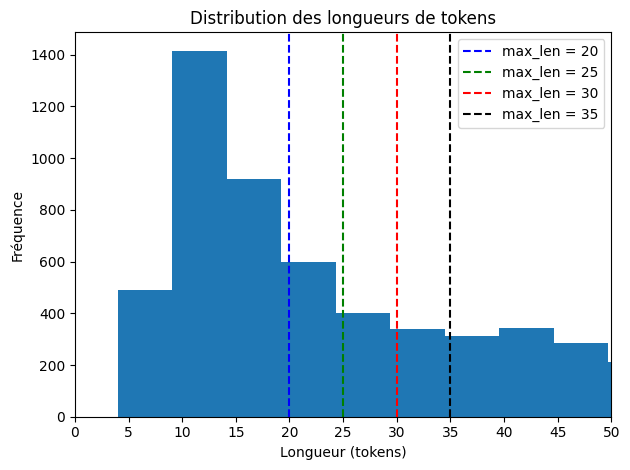

In [24]:

plt.hist(df['len'], bins=50)
plt.axvline(20, color='blue', linestyle='--', label='max_len = 20')
plt.axvline(25, color='green', linestyle='--', label='max_len = 25')
plt.axvline(30, color='red', linestyle='--', label='max_len = 30')
plt.axvline(35, color='black', linestyle='--', label='max_len = 35')
plt.xlim(0, 50)
plt.xticks(np.arange(0, 55, 5))
plt.title("Distribution des longueurs de tokens")
plt.xlabel("Longueur (tokens)")
plt.ylabel("Fréquence")
plt.legend()
plt.tight_layout()
plt.show()


Quand on regarde la distribution : 
 - 20 et 25 filtres trop de lignes
 - 30 rajoute 400 sms
 - 35 rajoute 340 sms

 Je vais bloquer à 35

In [25]:
def pad_sequences(sequences, max_length=35):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

df['token_pad'] = pad_sequences(df['token'])
df['len_pad']=df['token_pad'].apply(len)

On créé le dataset pytorch

In [26]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

class SmsDataset(Dataset):
    def __init__(self, df):
        self.texts = torch.tensor(df['token_pad'].tolist(), dtype=torch.long)
        self.labels = torch.tensor(df['target'].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Création du Dataset
train_dataset = SmsDataset(train_df)
val_dataset = SmsDataset(val_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [27]:
text, label = next(iter(train_loader))
print(text)

tensor([[36656,   885,   540,  ...,  1001,   945,  8190],
        [   40,   738,  3063,  ...,     0,     0,     0],
        [13022,   485,  8293,  ...,     0,     0,     0],
        ...,
        [   32, 17924,   261,  ..., 33567, 34827,  1008],
        [   33,  4905,  1073,  ...,   481, 12486,   668],
        [14999,   372,   485,  ...,     0,     0,     0]])


In [28]:
vocab_size = tokenizer.n_vocab
print(f'Le tokenizer o200k_base contient {vocab_size} tokens')

Le tokenizer o200k_base contient 200019 tokens


In [29]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        return self.fc(pooled)

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=32,
                      num_class=1)

print(model)

TextClassifier(
  (embedding): Embedding(200019, 32, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [30]:
summary(model, input_data=text)

Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 35, 32]              6,400,608
├─AdaptiveAvgPool1d: 1-2                 [32, 32, 1]               --
├─Linear: 1-3                            [32, 1]                   33
Total params: 6,400,641
Trainable params: 6,400,641
Non-trainable params: 0
Total mult-adds (M): 204.82
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 25.60
Estimated Total Size (MB): 25.90

In [31]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=50):

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):  
        model.train()  
        total_loss, correct = 0, 0  

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  
            outputs = model(inputs).squeeze(-1)  
            loss = criterion(outputs, labels.float())  
            loss.backward()  
            optimizer.step()  
            total_loss += loss.item()  
            correct += ((torch.sigmoid(outputs) > 0.5).long() == labels.long()).sum().item()  

        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation phase (without gradient computation)
        model.eval()  
        val_loss, val_correct = 0, 0
        with torch.no_grad():  
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze(-1)  
                loss = criterion(outputs, labels.float())  
                val_loss += loss.item()  
                val_correct += ((torch.sigmoid(outputs) > 0.5).long() == labels.long()).sum().item()  

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history 

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50)

Epoch [1/50], Loss: 0.6389, Acc: 0.7023, Val Loss: 0.5354, Val Acc: 0.8969
Epoch [2/50], Loss: 0.4366, Acc: 0.9053, Val Loss: 0.3580, Val Acc: 0.9103
Epoch [3/50], Loss: 0.2849, Acc: 0.9309, Val Loss: 0.2447, Val Acc: 0.9300
Epoch [4/50], Loss: 0.1926, Acc: 0.9545, Val Loss: 0.1797, Val Acc: 0.9489
Epoch [5/50], Loss: 0.1382, Acc: 0.9679, Val Loss: 0.1425, Val Acc: 0.9587
Epoch [6/50], Loss: 0.1054, Acc: 0.9729, Val Loss: 0.1203, Val Acc: 0.9641
Epoch [7/50], Loss: 0.0846, Acc: 0.9767, Val Loss: 0.1067, Val Acc: 0.9686
Epoch [8/50], Loss: 0.0706, Acc: 0.9796, Val Loss: 0.0974, Val Acc: 0.9722
Epoch [9/50], Loss: 0.0603, Acc: 0.9825, Val Loss: 0.0907, Val Acc: 0.9722
Epoch [10/50], Loss: 0.0519, Acc: 0.9845, Val Loss: 0.0855, Val Acc: 0.9731
Epoch [11/50], Loss: 0.0454, Acc: 0.9863, Val Loss: 0.0817, Val Acc: 0.9740
Epoch [12/50], Loss: 0.0400, Acc: 0.9879, Val Loss: 0.0786, Val Acc: 0.9749
Epoch [13/50], Loss: 0.0355, Acc: 0.9892, Val Loss: 0.0762, Val Acc: 0.9758
Epoch [14/50], Loss: 

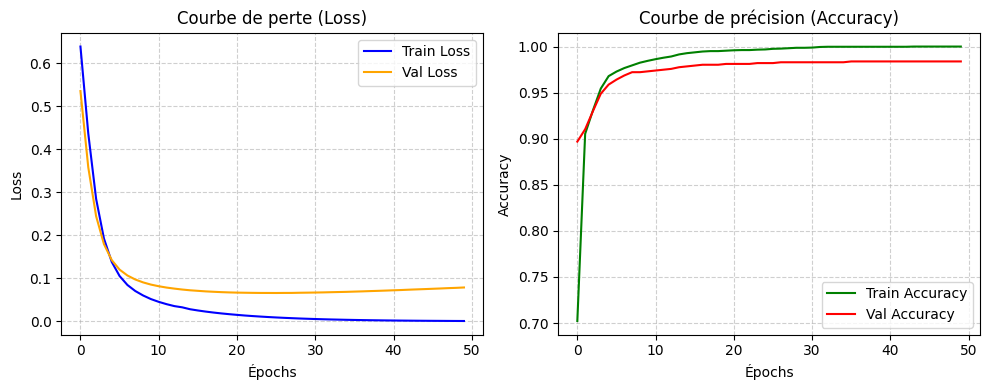

In [32]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='orange')
plt.title('Courbe de perte (Loss)')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Courbe de précision (Accuracy)')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Courbe de perte (Loss)

- Au niveau du Train, la courbe descend vite jusqu'à 0. il a donc bien appris
- Au niveau du Val, la courbe descend également vite et se stabilise juste au-dessus du Train.
- On ne voit pas de surapprentissage.


Courbe de précision (Accuracy) - proportion de prédictions correctes

- Au niveau du Train, la courbe finit à 1
- Au niveau du Val, la courbe plafonne un peu au-dessus de 0.98 ce qui est déjà très bien
- Bonne généralisation


📊 Rapport de classification :
              precision    recall  f1-score   support

         Ham      0.986     0.996     0.991       965
        Spam      0.971     0.907     0.938       150

    accuracy                          0.984      1115
   macro avg      0.979     0.951     0.964      1115
weighted avg      0.984     0.984     0.984      1115



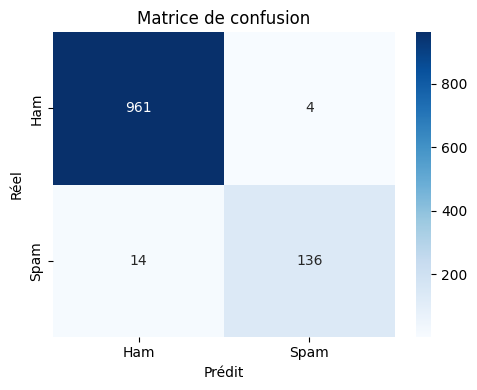

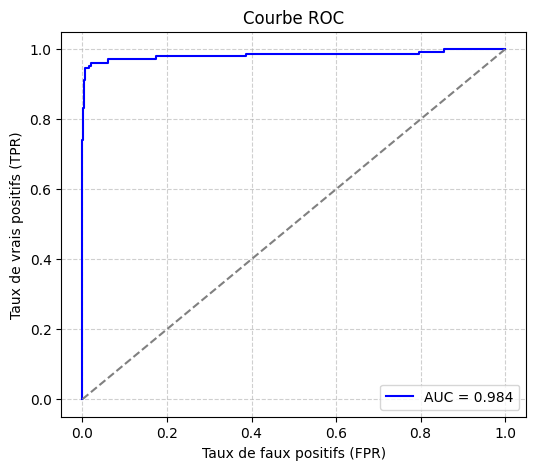

In [ ]:
model = model.to(device)
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs).squeeze()
        probs = torch.sigmoid(logits)              # Probabilités (entre 0 et 1)
        preds = (probs > 0.5).int()                # Seuil à 0.5

        # Rapatrier sur CPU pour scikit-learn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

print("📊 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=['Ham', 'Spam'], digits=3))

# --- Matrice de confusion ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

# --- Courbe ROC ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='blue')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


1. Matrice de confusion
Sur les 965 messages non SPAM, 961 sont prédits correctements et 4 sont prédits en SPAM.
Sur les 150 SPAM, 136 sont correctement prédits et 14 sont considérés comme non SPAM

Sur l'ensemble des messages non SPAM, nous avons le risque de perte de 4 messages.
Il est important de prédire au mieux les vrais messages quitte à laisser passer quelques SPAM. Le modèle semble correspondre à cet optique.


2. Courbe ROC et AUC
AUC = 0.984
Dans 98,4 % des cas, le modèle donne une probabilité plus élevée au vrai SPAM qu’à un ham aléatoire.

La courbe monte très rapidement vers le coin supérieur gauche ce qui indique que le modèle prédit les vrais positifs bien mieux que les faux positifs.

3. Rapport de classification
Classe	Précision	Recall	F1-score	Support
Ham	    0.986	    0.996	0.991	    965
Spam	0.971	    0.907	0.938	    150
Accuracy globale			0.984	    1115
🧠 Interprétation détaillée :

La précision (combien de vrais SPAM sur l'ensemble des SPAM prédits) - VP/VP+FP => 97.1 % des messages prédits comme spam sont réellement des spams.

Le Recall (combien de vrais SPAM sur l'ensemble des SPAM) - VP/VP+FN => 90.7 % des SPAM sont bien détectés.

Le F1-score (2*précision*recall/(précision+recall) Equilibre entre Recall et Précision => 93.8 % ce qui est un bon score.